In [7]:
import wandb, json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

api = wandb.Api(timeout=120)


runs = api.runs("emerge_/adaptive", filters={"tags": {"$in": ["ent_closerLook"]}})
print(len(runs))

buckets = defaultdict(lambda: {True: [], False: []})

for r in runs:
    # last logged value of environment/perf
    hist = r.history(keys=["environment/perf"])
    col = hist["environment/perf"].dropna() if "environment/perf" in hist else []
    v = float(col.iloc[-1]) if len(col) > 0 else None
    if v is None or not np.isfinite(v):
        continue

    # r.config may sometimes be a JSON string; normalize to dict
    cfg_obj = r.config
    if isinstance(cfg_obj, str):
        cfg_obj = json.loads(cfg_obj)

    cfg_env = cfg_obj.get("env")['value']
    ent = cfg_env.get("entropy_weight_ub", None)
    disc = cfg_env.get("discount_weight_lb", None)
    oracle = cfg_env.get("oracle_mode", None)
    print(ent, disc, oracle, v)

    ent = float(ent)
    disc = float(disc)

    buckets[(disc, ent)][oracle].append(v)

142
0.001 0.95 True 0.92022705078125
0.005 0.85 True 0.89129638671875
0.005 0.95 True 0.91229248046875
0.001 0.85 True 0.93145751953125
0.001 0.9 True 0.93524169921875
0.005 0.9 True 0.79998779296875
0.01 0.85 True 0.88934326171875
0.01 0.9 True 0.91192626953125
0.01 0.95 True 0.9202880859375
0.05 0.9 True 0.73284912109375
0.05 0.85 True 0.69854736328125
0.05 0.95 True 0.71624755859375
0.001 0.85 False 0.79669189453125
0.001 0.9 False 0.92645263671875
0.001 0.95 False 0.8814697265625
0.005 0.85 False 0.9158935546875
0.005 0.9 False 0.9222412109375
0.01 0.9 False 0.91876220703125
0.005 0.95 False 0.91461181640625
0.01 0.95 False 0.87603759765625
0.01 0.85 False 0.858642578125
0.05 0.85 False 0.68817138671875
0.05 0.9 False 0.7374267578125
0.05 0.95 False 0.65692138671875
0.001 0.85 False 0.82757568359375
0.001 0.9 False 0.933837890625
0.005 0.95 True 0.92803955078125
0.001 0.95 True 0.89727783203125
0.001 0.9 True 0.87677001953125
0.001 0.85 True 0.90283203125
0.005 0.85 True 0.89581298

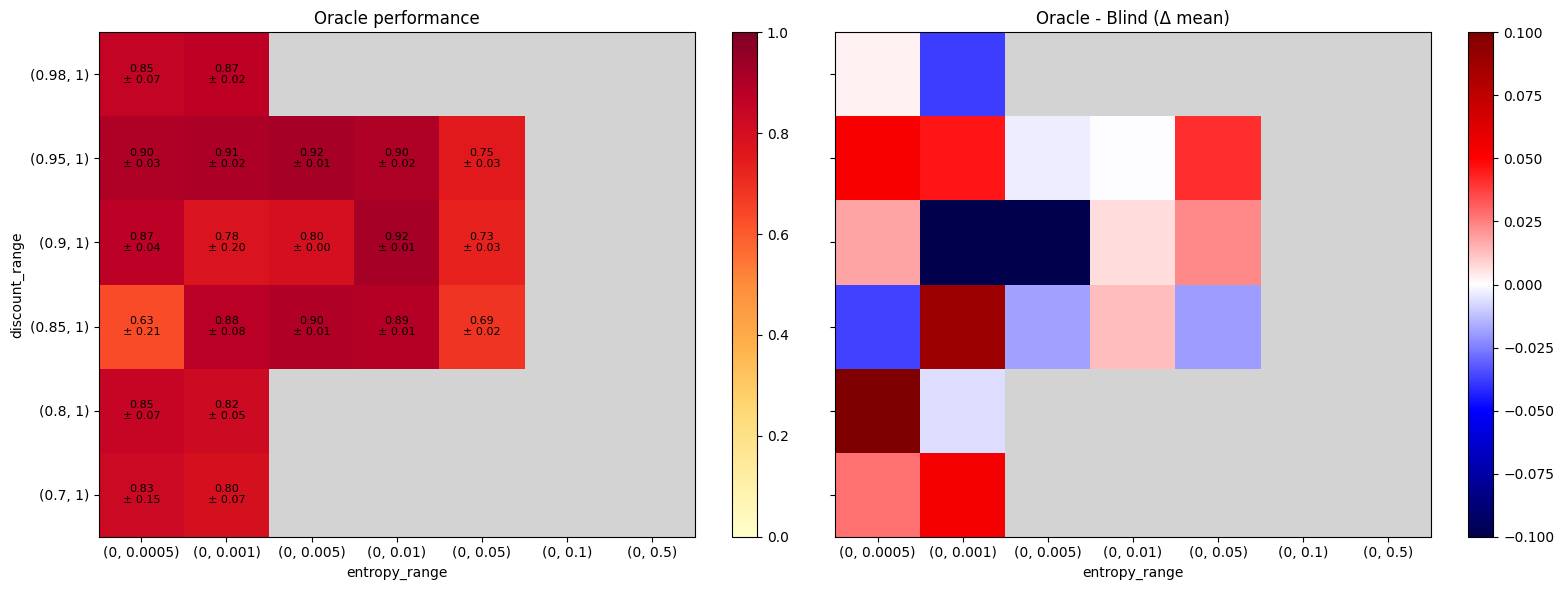

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm


entropy_values = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
discount_values = [0.70, 0.80, 0.85, 0.90, 0.95, 0.98]

M = np.full((len(discount_values), len(entropy_values)), np.nan)
mean = np.full((len(discount_values), len(entropy_values)), np.nan)
std = np.full((len(discount_values), len(entropy_values)), np.nan)
ent_idx = {e: i for i, e in enumerate(entropy_values)}
disc_idx = {d: i for i, d in enumerate(discount_values)}

for (disc, ent), d in buckets.items():
    if disc in disc_idx and ent in ent_idx and d[True] and d[False]:
        M[disc_idx[disc], ent_idx[ent]] = np.mean(d[True]) - np.mean(d[False])
        std[disc_idx[disc], ent_idx[ent]] = np.std(d[True])
        mean[disc_idx[disc], ent_idx[ent]] = np.mean(d[True])

# masks and colormaps
mean_ma = np.ma.masked_invalid(mean)
delta_ma = np.ma.masked_invalid(M)

perf_cmap = plt.cm.YlOrRd.copy()
perf_cmap.set_bad('lightgray')          # NaNs -> gray

delta_cmap = plt.cm.seismic.copy()
delta_cmap.set_bad('lightgray')

# color norms
perf_norm  = Normalize(vmin=0.0, vmax=1.0)
delta_norm = TwoSlopeNorm(vmin=-0.1, vcenter=0.0, vmax=0.1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# --- Left: Oracle performance (mean ± std) ---
im0 = axes[0].imshow(mean_ma, origin="lower", aspect="auto",
                     cmap=perf_cmap, norm=perf_norm)
for i in range(len(discount_values)):
    for j in range(len(entropy_values)):
        if not np.isnan(mean[i, j]):
            axes[0].text(j, i, f"{mean[i, j]:.2f}\n± {std[i, j]:.2f}",
                         ha="center", va="center", fontsize=8, color="black")
axes[0].set_title("Oracle performance")
axes[0].set_xlabel("entropy_range")
axes[0].set_ylabel("discount_range")
axes[0].set_xticks(range(len(entropy_values)))
axes[0].set_xticklabels([f"{(0, e)}" for e in entropy_values])
axes[0].set_yticks(range(len(discount_values)))
axes[0].set_yticklabels([f"{(d, 1)}" for d in discount_values])
cbar0 = fig.colorbar(im0, ax=axes[0])

# --- Right: Oracle advantage (Δ mean) ---
im1 = axes[1].imshow(delta_ma, origin="lower", aspect="auto",
                     cmap=delta_cmap, norm=delta_norm)
axes[1].set_title("Oracle - Blind (Δ mean)")
axes[1].set_xlabel("entropy_range")
axes[1].set_xticks(range(len(entropy_values)))
# e -> (0, e)
axes[1].set_xticklabels([f"{(0, e)}" for e in entropy_values])
cbar1 = fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 20th October: Plotting trained agents on diverse conditions

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from collections import defaultdict
from wandb import Api

def plot_puffer_drive(model_id):
    with open(f"/scratch/mmk9418/projects/PufferDrive/experiments/puffer_drive_{model_id}/eval_results.jsonl", 'r') as f:
        data = [json.loads(line.strip()) for line in f]

    entropy_weights = sorted(set([d['entropy_weight'] for d in data]))
    discount_weights = sorted(set([d['discount_weight'] for d in data]))

    entropy_idx = {ew: i for i, ew in enumerate(entropy_weights)}
    discount_idx = {dw: i for i, dw in enumerate(discount_weights)}

    combinations = [(-1.0, -0.4, 0.0), (0.0, 0.0, 1.0)]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

    perf_cmap = plt.cm.viridis.copy()
    perf_cmap.set_bad('lightgray')
    perf_norm = Normalize(vmin=0.0, vmax=1.0)
    run = Api().run(f"emerge_/adaptive/{model_id}")
    env_cfg = run.config['env']

    for idx, (cw, ow, gw) in enumerate(combinations):
        ax = axes[idx]
        
        filtered_data = [d for d in data if d['collision_weight'] == cw and d['offroad_weight'] == ow and d['goal_weight'] == gw]
        
        grouped = defaultdict(list)
        for d in filtered_data:
            grouped[(d['entropy_weight'], d['discount_weight'])].append(d['perf'])
        
        mean_matrix = np.full((len(discount_weights), len(entropy_weights)), np.nan)
        
        for (ew, dw), perfs in grouped.items():
            mean_matrix[discount_idx[dw], entropy_idx[ew]] = np.mean(perfs)
        
        mean_ma = np.ma.masked_invalid(mean_matrix)
        
        im = ax.imshow(mean_ma, origin="lower", aspect="auto", cmap=perf_cmap, norm=perf_norm)
        
        for i in range(len(discount_weights)):
            for j in range(len(entropy_weights)):
                if not np.isnan(mean_matrix[i, j]):
                    ax.text(j, i, f"{mean_matrix[i, j]:.3f}",
                        ha="center", va="center", fontsize=8, color="black")
        
        ax.set_title(f"Collision: {cw}, Offroad: {ow}, Goal: {gw}")
        ax.set_xlabel("Entropy Weight")
        ax.set_ylabel("Discount Weight")
        ax.set_xticks(range(len(entropy_weights)))
        ax.set_xticklabels([f"{ew:.1e}" for ew in entropy_weights])
        ax.set_yticks(range(len(discount_weights)))
        ax.set_yticklabels([f"{dw:.1e}" for dw in discount_weights])
        # add a red line at entropy_weight_ub and discount_weight_lb
        # ax.axvline(x=entropy_idx[env_cfg['entropy_weight_ub']]+0.5, ymin=discount_idx[env_cfg['discount_weight_lb']] / len(discount_weights), ymax=1, color='red', linestyle='--')
        # ax.axhline(y=discount_idx[env_cfg['discount_weight_lb']]-0.5, xmin=0, xmax=(entropy_idx[env_cfg['entropy_weight_ub']]+1)/ len(entropy_weights), color='red', linestyle='--')

    plt.suptitle(f"Model: {model_id}, EW: ({env_cfg['entropy_weight_lb']}, {env_cfg['entropy_weight_ub']}), DW: ({env_cfg['discount_weight_lb']}, {env_cfg['discount_weight_ub']}), Oracle: {env_cfg['oracle_mode']}, Conditioned: {env_cfg['condition_type']}")
    fig.colorbar(im, ax=axes.ravel().tolist(), label='Performance')
    plt.show()

model_id1 = "ctixaqro" # blind
model_id2 = "k9e9eblt" # oracle

# model_id1 = "wfxrqwzu"
# model_id2 = "9kcvwqpc"

# model_id1 = "hxyxto8s"
# model_id2 = "rnr2okmt"

plot_puffer_drive(model_id1)
plot_puffer_drive(model_id2)

# plot_puffer_drive(model_id = "0h30xi4y")
# plot_puffer_drive(model_id = "myb990xc")

# plot_puffer_drive(model_id = "1fw9gf98")
# plot_puffer_drive(model_id = "6zu4o36e")

# plot_puffer_drive(model_id = "2fj7fj3p")
# plot_puffer_drive(model_id = "1tn6kogv")

ModuleNotFoundError: No module named 'numpy'

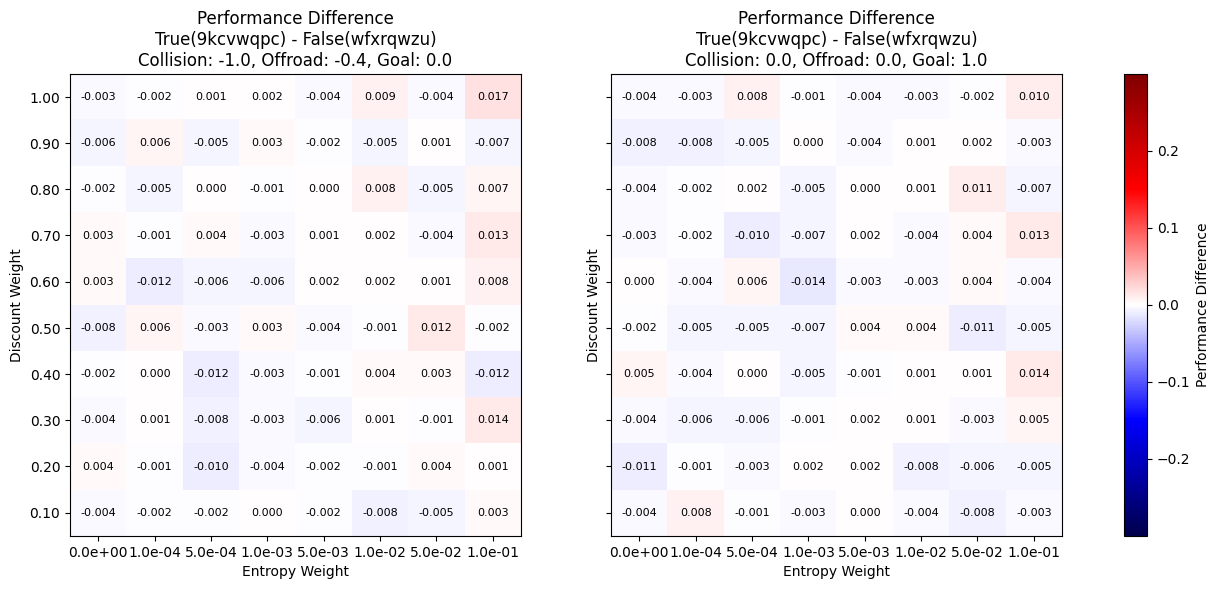

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from collections import defaultdict

# model_id1 = "1fw9gf98"
# model_id2 = "6zu4o36e"

# model_id1 = "0h30xi4y"
# model_id2 = "myb990xc"

def load_model_data(model_id):
    with open(f"/scratch/mmk9418/projects/PufferDrive/experiments/puffer_drive_{model_id}/eval_results.jsonl", 'r') as f:
        data = [json.loads(line.strip()) for line in f]
    
    entropy_weights = sorted(set([d['entropy_weight'] for d in data]))
    discount_weights = sorted(set([d['discount_weight'] for d in data]))
    
    entropy_idx = {ew: i for i, ew in enumerate(entropy_weights)}
    discount_idx = {dw: i for i, dw in enumerate(discount_weights)}
    
    return data, entropy_weights, discount_weights, entropy_idx, discount_idx

data1, entropy_weights, discount_weights, entropy_idx, discount_idx = load_model_data(model_id1)
data2, _, _, _, _ = load_model_data(model_id2)

def get_matrix(data, cw, ow, gw):
    filtered_data = [d for d in data if d['collision_weight'] == cw and d['offroad_weight'] == ow and d['goal_weight'] == gw]
    
    grouped = defaultdict(list)
    for d in filtered_data:
        grouped[(d['entropy_weight'], d['discount_weight'])].append(d['perf'])
    
    mean_matrix = np.full((len(discount_weights), len(entropy_weights)), np.nan)
    
    for (ew, dw), perfs in grouped.items():
        mean_matrix[discount_idx[dw], entropy_idx[ew]] = np.mean(perfs)
    
    return mean_matrix

combinations = [(-1.0, -0.4, 0.0), (0.0, 0.0, 1.0)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

delta_cmap = plt.cm.seismic.copy()
delta_cmap.set_bad('lightgray')
delta_norm = TwoSlopeNorm(vmin=-0.3, vcenter=0.0, vmax=0.3)
run1 = Api().run(f"emerge_/adaptive/{model_id1}")
env_cfg1 = run1.config['env']
run2 = Api().run(f"emerge_/adaptive/{model_id2}")
env_cfg2 = run2.config['env']

for idx, (cw, ow, gw) in enumerate(combinations):
    ax = axes[idx]
    
    matrix1 = get_matrix(data1, cw, ow, gw)
    matrix2 = get_matrix(data2, cw, ow, gw)
    
    diff_matrix = matrix2 - matrix1
    diff_ma = np.ma.masked_invalid(diff_matrix)
    
    im = ax.imshow(diff_ma, origin="lower", aspect="auto", cmap=delta_cmap, norm=delta_norm)
    
    for i in range(len(discount_weights)):
        for j in range(len(entropy_weights)):
            if not np.isnan(diff_matrix[i, j]):
                ax.text(j, i, f"{diff_matrix[i, j]:.3f}",
                       ha="center", va="center", fontsize=8, color="black")

    # ax.axvline(x=entropy_idx[env_cfg1['entropy_weight_ub']]+0.5, ymin=discount_idx[env_cfg1['discount_weight_lb']] / len(discount_weights), ymax=1, color='black', linestyle='--')
    # ax.axhline(y=discount_idx[env_cfg1['discount_weight_lb']]-0.5, xmin=0, xmax=(entropy_idx[env_cfg1['entropy_weight_ub']]+1)/ len(entropy_weights), color='black', linestyle='--')
    
    ax.set_title(f"Performance Difference\n{env_cfg2['oracle_mode']}({model_id2}) - {env_cfg1['oracle_mode']}({model_id1})\nCollision: {cw}, Offroad: {ow}, Goal: {gw}")
    ax.set_xlabel("Entropy Weight")
    ax.set_ylabel("Discount Weight")
    ax.set_xticks(range(len(entropy_weights)))
    ax.set_xticklabels([f"{ew:.1e}" for ew in entropy_weights])
    ax.set_yticks(range(len(discount_weights)))
    ax.set_yticklabels([f"{dw:.2f}" for dw in discount_weights])

fig.colorbar(im, ax=axes.ravel().tolist(), label='Performance Difference')

plt.show()
